# 시험장 환경 정보

Python: 3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]

|모듈|버젼|
|----|----|
|pandas|0.25.1|
|numpy|1.18.5|
|sklearn|0.21.3|
|scipy|1.5.2|
|mlxtend|0.15.0.0|
|statsmodels|0.11.1|
|xgboost|0.80|

In [120]:
# 실행 환경 확인

import pandas as pd
import numpy as np
import sklearn
import scipy
import statsmodels
import mlxtend
import xgboost as xgb
import sys


print(sys.version)
for i in [pd, np, sklearn, scipy, mlxtend, statsmodels, xgb]:
    print(i.__name__, i.__version__)

3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]
pandas 0.25.1
numpy 1.18.5
sklearn 0.21.3
scipy 1.5.2
mlxtend 0.15.0.0
statsmodels 0.11.1
xgboost 0.80


In [2]:
# 시각화 모듈 설정
# 참고용 차트를 출력하기 위함
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
import matplotlib.font_manager as fm
plt.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False

# 문제 개요


생활가전 A부서는 친환경 미니 세탁기를 개발 중에 있다. 

프로젝트의 핵심은 세탁물을 자동 인식하고 이에 따른 최적 코스를 (수량, 수온, 세제종류, 세제량, 세탁시간, 세탁방법) 제시하여 세탁지수(target)를 높이는 것이다. 

이를 위해 세탁지수에 영향을 주는 빨랫감의 종류와 오염량, 급수량, 세제종류, 투입량 등을 측정한 데이터를 확보하였다. 

데이터의 변수명은 보안을 위해 cat0, cont0등으로 코드화 되어 있다.

아래 데이터를 사용하여 과제를 해결하고 세탁지수(target)를 예측하시오.

데이터 구성

학습데이터: train_prob.csv, 240,000 rows, 26 columns

테스트데이터: test_prob.csv, 60,000 rows, 25 columns

테스트정답셋: test_prob_ans.csv, 60,000 rows, 1 columns

|변수명|설명|타입|
|------|----|----|
|Id|실험 고유 번호|정수형|
|cat0 ~ cat9|범주형 변수 0~9|문자형|
|cont0 ~ cont13|연속형 변수 0~13|실수형|
|target|세탁지수|실수형|


# 전처리(Preprocessing)

train_prob.csv 데이터셋을 대상으로 다음 전처리를 진행하라.

In [3]:
df_train = pd.read_csv('train_prob.csv', index_col='id')
df_train.head()

cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...    cont5  \
id                                                        ...            
267387    A    B    B    C    B    B    A    E    G    G  ...  0.22443   
410037    A    A    A    A    B    B    A    E    C    F  ...  0.43278   
139373    A    A    B    A    B    B    A    E    C    J  ...  0.36238   
113765    A    A    A    C    B    B    A    E    C    G  ...  0.32670   
179915    A    B    A    C    B    B    A    E    E    L  ...  0.20121   

          cont6    cont7    cont8    cont9   cont10   cont11   cont12  \
id                                                                      
267387  0.69220  0.30912  0.47134  0.53290  0.97139  0.59414  0.36856   
410037  0.97199  0.62596  0.40193  0.49181  0.56479  0.39386  0.36247   
139373  0.41310  0.27010  0.40112  0.53052  0.35635  0.33341  0.33354   
113765  0.42301  0.28331  0.46425  0.38302  0.38054  0.68827  0.34895   
179915  0.37466  0.46316  0.75578  0.55676  0.31308  0.43157  0.32302   

         cont13   target  
id                        
267387  0.42951  8.13741  
410037  0.71541  7.40427  
139373  0.82542  7.98022  
113765  0.73375  7.26085  
179915  0.18028  7.26448  

[5 rows x 25 columns]

## 단계 1

target은 2개의 정규 분포가 합쳐진 모양을 하고 있다. 

두 분포의 구분점 7.45를 기준으로 target값이 작거나 같으면 A, 초과하면 B로 나눈다.

A 범주이면 True, B이면 False인 파생 변수 target A를 만든다.

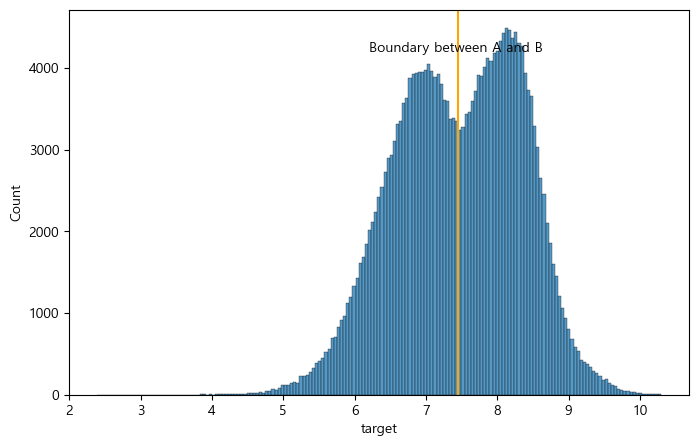

In [4]:
# target의 히스토그램 출력 및 구분선 출력합니다
plt.figure(figsize=(8, 5))
sns.histplot(data=df_train, x='target')
plt.axvline(7.45, c='orange')
plt.gca().annotate("Boundary between A and B", (6.2, 4200))
plt.show()

In [5]:
df_train['targetA'] = df_train['target'] <= 7.45
df_train.head()

cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...    cont6  \
id                                                        ...            
267387    A    B    B    C    B    B    A    E    G    G  ...  0.69220   
410037    A    A    A    A    B    B    A    E    C    F  ...  0.97199   
139373    A    A    B    A    B    B    A    E    C    J  ...  0.41310   
113765    A    A    A    C    B    B    A    E    C    G  ...  0.42301   
179915    A    B    A    C    B    B    A    E    E    L  ...  0.37466   

          cont7    cont8    cont9   cont10   cont11   cont12   cont13  \
id                                                                      
267387  0.30912  0.47134  0.53290  0.97139  0.59414  0.36856  0.42951   
410037  0.62596  0.40193  0.49181  0.56479  0.39386  0.36247  0.71541   
139373  0.27010  0.40112  0.53052  0.35635  0.33341  0.33354  0.82542   
113765  0.28331  0.46425  0.38302  0.38054  0.68827  0.34895  0.73375   
179915  0.46316  0.75578  0.55676  0.31308  0.43157  0.32302  0.18028   

         target  targetA  
id                        
267387  8.13741    False  
410037  7.40427     True  
139373  7.98022    False  
113765  7.26085     True  
179915  7.26448     True  

[5 rows x 26 columns]

## 단계 2

cat3 ~ 9 각각의 범주 중에서 빈도가 적은 범주를 target을 예측하는데 영향이 없는 방향으로 정리하려고 한다. 

아래 가이드에 맞추어 cat3 ~ 9 에 대한 전처리를 수행한다.

* cat3는 B→C 로 치환한다.

Hint] 치환 후의 빈도 테이블

|A|C|D|
|-|-|-|
|83,634|147,361|9,005|

* cat4는 A→B, D→B 로 치환한다.

Hint] 치환 후의 빈도 테이블

|B|C|
|-|-|
|239,397|603|

* cat6는 D→A, E→B, G→C, H→B, I→A로 치환한다.

Hint] 치환 후의 빈도 테이블

|A|B|C|
|-|-|-|
|234,203|5,145|652|

* cat7는 A→B, C→B, F→D, I→B로 치환한다.

Hint] 치환 후의 빈도 테이블

|B|D|E|G|
|-|-|-|-|
|4,606|19,784|214,027|1,583|

* cat8는 B→G, F→E로 치환한다.

Hint] 치환 후의 빈도 테이블

|A|C|D|E|G|
|-|-|-|-|-|
|30,338|96,743|2,953|76,085|33,881|

* cat9는 C→H, D→B, E→L로 치환한다.

Hint] 치환 후의 빈도 테이블

|A|B|F|G|H|I|J|K|L|M|N|O|
|-|-|-|-|-|-|-|-|-|-|-|-|
|10,678|2,846|85,944|8,320|19,987|40,070|5,501|16,743|33,793|7,819|3,331|4,968|


In [6]:
# 위의 과정은 동일한 과정을 여러 변수를 대상으 진행하고 있습니다.
# 하나의 케이스에 대해서 과정을 만들어 보고, 반복문을 통해 나머지도 처리하도록 합니다.
# replace 함수를 이용하여 B -> C로 바꾸고, 확인을 위해 value_counts를 하여 갯수를 비교합니다.
# value_counts는 빈도수로 정렬이 되서 나오는데요, 확인을 위해 제공한 카운트는 알파벳순으로 되어 있습니다.
# 따라서 index로 정렬해야 순서 맞춰 비교할 수 있게 됩니다.
# 로직만을 설계해봅니다.
df_train['cat3'].replace({'B': 'C'}).value_counts().sort_index() != [83634, 147361, 9005]

A    False
C    False
D    False
Name: cat3, dtype: bool

In [7]:
# 처리할 내용을 튜플과 리스트로 만듭니다.
repl_list = [
    ('cat3', {'B': 'C'}, [83634, 147361, 9005]),
    ('cat4', {'A': 'B', 'D': 'B'}, [239397, 603]), 
    ('cat6', {'D': 'A', 'E': 'B', 'G': 'C', 'H': 'B', 'I': 'A'}, [234203, 5145, 652]),
    ('cat7', {'A': 'B', 'C': 'B', 'F': 'D', 'I': 'B'}, [4606, 19784, 214027, 1583]),
    ('cat8', {'B': 'G', 'F': 'E'}, [30338, 96743, 2953, 76085, 33881]),
    ('cat9', {'C': 'H', 'D': 'B', 'E': 'L'}, [10678, 2846, 85944, 8320, 19987, 40070, 5501, 16743, 33793, 7819, 3331, 4968])
]

In [8]:
# 반복문을 통해 처리합니다.
for c, d, cnt in repl_list:
    # 위에서 설계한 로직을 적용합니다.
    # 처리한 값을 저장합니다.
    df_train[c] = df_train[c].replace(d)
    # 카운트가 다른 게 있는지 확인 합니다.
    if (df_train[c].value_counts().sort_index() != cnt).sum() != 0:
        print('error', c, d, cnt)
    print(c, d, cnt)

cat3 {'B': 'C'} [83634, 147361, 9005]
cat4 {'A': 'B', 'D': 'B'} [239397, 603]
cat6 {'D': 'A', 'E': 'B', 'G': 'C', 'H': 'B', 'I': 'A'} [234203, 5145, 652]
cat7 {'A': 'B', 'C': 'B', 'F': 'D', 'I': 'B'} [4606, 19784, 214027, 1583]
cat8 {'B': 'G', 'F': 'E'} [30338, 96743, 2953, 76085, 33881]
cat9 {'C': 'H', 'D': 'B', 'E': 'L'} [10678, 2846, 85944, 8320, 19987, 40070, 5501, 16743, 33793, 7819, 3331, 4968]


In [9]:
df_basetable = df_train.copy()

# 문제1

범주형 변수의 조합의 특성을 파악하고자 한다. 다음 과정을 수행하라.

## 단계 1-1

basetable을 복사하여 prob1을 만들고 cat0 ~ 9 변수 순서대로 문자열 결합하여, 10자리 문자형 파생 변수(cat_c)를 생성하라.

In [10]:
cat_cols = ['cat{}'.format(i) for i in range(10)]
#df_basetable[cat_cols].apply(lambda x: ''.join(x), axis=1)
df_prob1 = df_basetable.assign(
    cat_c = lambda x: x[cat_cols].apply(lambda x: x.str.cat(), axis=1)
)
df_prob1.head()

cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...    cont7  \
id                                                        ...            
267387    A    B    B    C    B    B    A    E    G    G  ...  0.30912   
410037    A    A    A    A    B    B    A    E    C    F  ...  0.62596   
139373    A    A    B    A    B    B    A    E    C    J  ...  0.27010   
113765    A    A    A    C    B    B    A    E    C    G  ...  0.28331   
179915    A    B    A    C    B    B    A    E    E    L  ...  0.46316   

          cont8    cont9   cont10   cont11   cont12   cont13   target  \
id                                                                      
267387  0.47134  0.53290  0.97139  0.59414  0.36856  0.42951  8.13741   
410037  0.40193  0.49181  0.56479  0.39386  0.36247  0.71541  7.40427   
139373  0.40112  0.53052  0.35635  0.33341  0.33354  0.82542  7.98022   
113765  0.46425  0.38302  0.38054  0.68827  0.34895  0.73375  7.26085   
179915  0.75578  0.55676  0.31308  0.43157  0.32302  0.18028  7.26448   

        targetA       cat_c  
id                           
267387    False  ABBCBBAEGG  
410037     True  AAAABBAECF  
139373    False  AABABBAECJ  
113765     True  AAACBBAECG  
179915     True  ABACBBAEEL  

[5 rows x 27 columns]

## 단계 1-2

50개 이상 행으로 이루지고, target에 대한 정규성을 부정할 수 없는 cat_c를 찾아 cat_c_A와 cat_c_B를 구하라. 

정규성 검정은 Kolmogolov-Smironov 검정을 사용한다. (유의 수준: 5%)

- cat_c의 행의 개수가 많은 순으로 cat_c 3개를 cat_c_A

- cat_c의 행의 개수가 적은 순으로 cat_c 3개를 cat_c_B

* 행의 개수가 같을 경우에는 p-value가 높은 순으로 고른다.

---
**함수가이드**

scipy.stats 제공 기능 활용

문제 지시사항 외 Default 값 사용

---


In [11]:
from scipy.stats import kstest, norm
import functools
# 하나의 샘플셋을 대상으로 kstest를합니다. 
# kstest는 두 개의 집단 또는 하나의 집단과 누적분포함수가 같은 분포인지 아닌지 검정합니다.
# kstest의 입력으로, 샘플들의 리스트 정규분포의 누적분포함수 (norm.cdf)의 전달을 통해
# 정규정 검정을 수행토록합니다.
# norm.cdf의 기본 설정은 표준정규분포입니다.
# 1. 입력 샘플들을 표준화해서 전달합니다.
# 2. 누적분포함수의 설정을 샘플들의 평균과, 표준편차로 설정합니다. (functools이 partial을 이용했습니다.)
sam = df_prob1.loc[df_prob1['cat_c'] == 'AAAABBAECF', 'target']
(
    kstest((sam - sam.mean()) / sam.std(), norm.cdf), # 1
    kstest(sam, functools.partial(norm.cdf, loc=sam.mean(), scale=sam.std())) # 2
)

(KstestResult(statistic=0.06085563823469553, pvalue=2.165306258680074e-21),
 KstestResult(statistic=0.06085563823469553, pvalue=2.165306258680074e-21))

In [12]:
# 방법1: GroupBy
# groupby ~ filter를 통해 50개의 이상인 행들을 대상으로 합니다.
# 다시 cat_c에 대해 구분을 합니다.
# kstest를 진행을 하고, cat_c에 따라 stats, pval 나타내는 DataFrame을 만듭니다.
# cat_c의 빈도수를 join을 통해 붙입니다.
df_kstest = df_prob1.groupby('cat_c').filter(lambda x: len(x) >= 50)\
        .groupby('cat_c')['target']\
        .apply(lambda x: pd.Series(kstest((x - x.mean()) / x.std(), norm.cdf), index=['stats', 'pval']))\
        .unstack()\
        .join(df_prob1['cat_c'].value_counts().rename('cnt'))
df_kstest.sort_values('cnt', ascending=False)

stats          pval   cnt
cat_c                                   
AAAABBAECF  0.060856  2.165306e-21  6507
AAAABDAECF  0.089300  1.709063e-41  5915
ABACBBAEEL  0.051439  1.763877e-10  4366
AAACBBAECF  0.053636  8.357369e-11  4145
AAACBDAECF  0.077939  1.172657e-19  3636
...              ...           ...   ...
AAACBCAEEI  0.071563  9.438446e-01    50
ABBCBDAECG  0.098339  6.821673e-01    50
ABAABDAEEK  0.138754  2.653299e-01    50
BBAABDAEEF  0.060599  9.876562e-01    50
AAAABDAEAM  0.090387  7.749260e-01    50

[626 rows x 3 columns]

In [15]:
# 방법 2: 반복문을 이용한 방법
# cat_c의 빈도수를 구합니다.
# v_cnt는 빈도수에 대하여 내림차순 정렬이 되어 있습니다.
v_cnt = df_prob1['cat_c'].value_counts()
cat_c_ = []
# k: cat_c, v 는 빈도수입니다.
for k, v in v_cnt.items():
    # 빈도수가 50보다 작으면 멈춥니다.
    if v < 50:
        break
    # ks 검정을 합니다.
    result = kstest(
        df_prob1.loc[df_prob1["cat_c"] == k,'target'].pipe(lambda x: (x - x.mean()) / x.std()), 
        norm.cdf
    )
    """
    #정규성을 부정할 수 없는것 고르 것을 여기서 정규성 조건을 반영할 수도 있습니다. 
    if result.pvalue >= 0.05:
        cat_c_.append((k, result, v))
    """
    cat_c_.append((k, result, v))
df_kstest = pd.DataFrame({'cat_c': [i[0] for i in cat_c_],
                         'statistic': [i[1].statistic for i in cat_c_],
                         'pval': [i[1].pvalue for i in cat_c_],
                         'cnt': [i[2] for i in cat_c_]}).set_index('cat_c')
df_kstest

statistic          pval   cnt
cat_c                                    
AAAABBAECF   0.060856  2.165306e-21  6507
AAAABDAECF   0.089300  1.709063e-41  5915
ABACBBAEEL   0.051439  1.763877e-10  4366
AAACBBAECF   0.053636  8.357369e-11  4145
AAACBDAECF   0.077939  1.172657e-19  3636
...               ...           ...   ...
AAACBBAEDH   0.168909  1.024057e-01    50
BBAABDAEEF   0.060599  9.876562e-01    50
ABBABBAECI   0.048159  9.994752e-01    50
AAAABDAEAM   0.090387  7.749260e-01    50
ABAABDAEEK   0.138754  2.653299e-01    50

[626 rows x 3 columns]

In [16]:
df_kstest = df_kstest.query('pval >= 0.05').sort_values(['cnt', 'pval'], ascending=[False, True])
df_kstest

statistic      pval   cnt
cat_c                                
ABACBBAEEI   0.030799  0.054494  1888
AAAABBAEEI   0.040326  0.099566   914
AAACBDAEGI   0.044676  0.057831   880
AAACBBAEEA   0.045374  0.066533   819
AAACBBAEEH   0.036724  0.216905   814
...               ...       ...   ...
ABBCBDAEEM   0.077785  0.899734    50
AAACBCAEEI   0.071563  0.943845    50
ABADBDAEAL   0.067553  0.964781    50
BBAABDAEEF   0.060599  0.987656    50
ABBABBAECI   0.048159  0.999475    50

[500 rows x 3 columns]

In [17]:
cat_c_A, cat_c_B = df_kstest.iloc[:3].index.tolist(), df_kstest.iloc[-3:].index.tolist()
cat_c_A, cat_c_B 

(['ABACBBAEEI', 'AAAABBAEEI', 'AAACBDAEGI'],
 ['ABADBDAEAL', 'BBAABDAEEF', 'ABBABBAECI'])

## 단계 1-3

bartlett 검정을 사용하여 cat_c_A에 해당하는 범주간에 target의 등분산성을 조사했을 때 검정 통계량을 A라 한다. 

그리고 bartlett 검정을 사용하여 cat_c_B에 해당하는 범주간에 target의 등분산성을 조사했을 때 검정 통계량을 B라고 한다. 


---
**함수가이드**

scipy.stats 제공 기능 활용

문제 지시사항 외 Default 값 사용

---

In [18]:
from scipy.stats import bartlett
result_1_3_1 = bartlett(
    *df_prob1.loc[df_prob1['cat_c'].isin(cat_c_A)]\
            .groupby('cat_c')['target'].agg(list).tolist()
)
A = result_1_3_1.statistic
result_1_3_1, A

(BartlettResult(statistic=9.478560380242815, pvalue=0.00874493861372744),
 9.478560380242815)

In [19]:
result_1_3_2 = bartlett(
    *df_prob1.loc[df_prob1['cat_c'].isin(cat_c_B)]\
            .groupby('cat_c')['target'].agg(list).tolist()
)
B = result_1_3_2.statistic
result_1_3_2, B

(BartlettResult(statistic=0.4140582984181041, pvalue=0.8129959514532286),
 0.4140582984181041)

## 단계 1-4

등분산성을 부정할 수 없는 경우는 경우는 단 하나 있다. (유의 수준: 5%)

이 경우에 해당하는 행들을 대상으로 해당 범주 3개에 대한 분산분석(ANOVA)를 수행하고 p-value를 C라고 한다. 

---
**함수가이드**

scipy.stats 제공 기능 활용

문제 지시사항 외 Default 값 사용

---

In [20]:
from scipy.stats import f_oneway
result_1_4 = f_oneway(
    *df_prob1.loc[df_prob1['cat_c'].isin(cat_c_B)]\
            .groupby('cat_c')['target'].agg(list).tolist()
)
C = result_1_4.pvalue
result_1_4, C

(F_onewayResult(statistic=0.1660465473994472, pvalue=0.8471654486810101),
 0.8471654486810101)

In [21]:
A, B, C, A + B + C, round(A + B + C, 3)

(9.478560380242815,
 0.4140582984181041,
 0.8471654486810101,
 10.739784127341927,
 10.74)

A + B + C 를 소수점 넷째 자리에서 반올림하여 셋째 자리까지 표시하라.

**10.740**

# 문제 2

연속형 변수 cont0 ~ 13 중에서, 서로 피어슨 상관도(Pearson correlation)가 높은 변수들 찾고, 

이들을 PCA를 통한 차원 축소를 하여 성능 향상이 있는지 확인하고자 한다.

## 단계 2-1

basetable 에서 인덱스와 컬럼 모두 cont0 ~ 13이고, 

인덱스와 컬럼에 해당하는 변수 간에 피어슨 상관도(Pearson correlation)를 값으로 하는 대각 대칭형인 데이터프레임을 corr을 만든다.

In [22]:
cont_cols = ['cont{}'.format(i) for i in range(14)]
df_corr = df_basetable[cont_cols].corr()
df_corr.head()

cont0     cont1     cont2     cont3     cont4     cont5     cont6  \
cont0  1.000000 -0.123344 -0.268621  0.255262 -0.108197  0.573894  0.301672   
cont1 -0.123344  1.000000  0.174625 -0.153110 -0.035455 -0.064297  0.099449   
cont2 -0.268621  0.174625  1.000000 -0.216238  0.047065 -0.291732 -0.050488   
cont3  0.255262 -0.153110 -0.216238  1.000000 -0.048677  0.253592  0.059515   
cont4 -0.108197 -0.035455  0.047065 -0.048677  1.000000 -0.166160 -0.175280   

          cont7     cont8     cont9    cont10    cont11    cont12    cont13  
cont0  0.300353  0.579618  0.524481  0.394401  0.425350  0.473249  0.039613  
cont1 -0.091482 -0.105811 -0.035944  0.070926  0.060877 -0.080143 -0.034036  
cont2 -0.213688 -0.278496 -0.227655 -0.071688 -0.107875 -0.329195 -0.054582  
cont3  0.215057  0.264717  0.220375  0.099694  0.131967  0.253720  0.043121  
cont4 -0.105320 -0.136829 -0.150984 -0.187024 -0.199560 -0.127953 -0.012127

## 단계 2-2

계층적 군집화를 활용하여 다음 개념도(실제 결과와는 상관 없음)와 같이 연관성이 높은 변수 군집을 찾아 보고자 한다. 

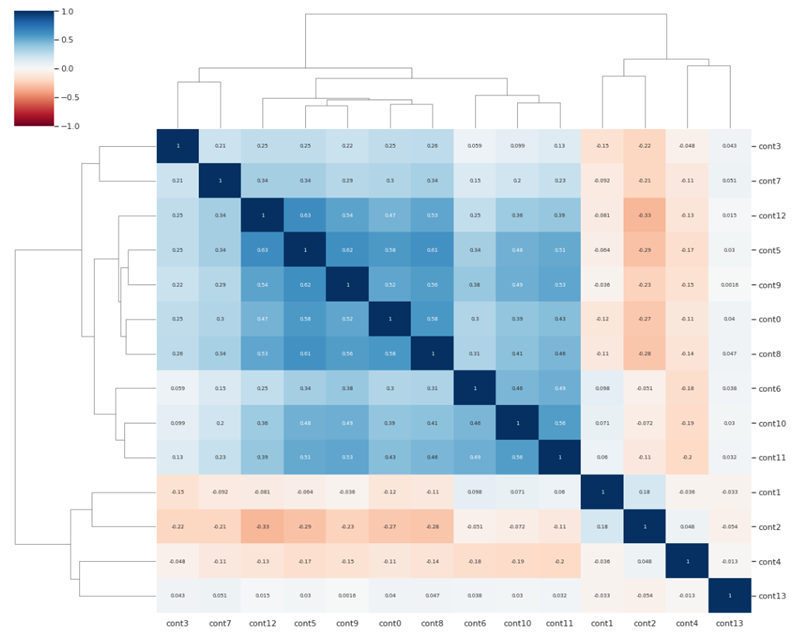

초기에는 cont0~13 변수 각각을 하나의 군집으로 배정한 상태에서 시작하여, 

군집 간 결합 조건으로 두 군집에 포함된 변수간의 피어슨 상관도 절대값의 평균이 0.5이상 일 때, 

해당 수치가 높은 것을 우선으로 군집들을 결합한다. 군집의 크기가 가장 큰 변수들을 구하라.


Hint] cont0 ~ 13간의 거리는 [단계 2-1] corr을 이용하여 군집 결합 조건을 고려하여 구한다. 

    (두 변수간에 피어슨 상관도의 절대값이 높을 수록 거리는 가깝다.)

---
**함수가이드**

sklearn.cluster.AgglomerativeClustering

문제 지시사항 외 Default 값 사용

---

In [23]:
from sklearn.cluster import AgglomerativeClustering

# 상관도를 거리의 개념으로 바꿉니다. 
# pearson상관도는 [-1, 1] 구간에 있고, 1이나 -1에 가까울 수록 상관도는 높다고 할 수 있습니다.
# 거리는 작을수록 가깝다고 할 수 있습니다.
# 즉 pearson 상관도를 거리의 개념으로 바꿀 필요하 있는데요, 
# 절대값을 취해 역수로 바꾸면 문제에서 제시한 조건을 반영하기 힘듭니다.
# 반면 절대값에 -를 취하면 [-1, 0] 이 되고 1에서 이 값을 빼게 하여 
# [0, 1] 범위로 맞춰 주게 합니다. 이는 곧 거리의 기준을 산정하기에 용의하게 해줍니다.
df_dist = 1 - df_corr.abs()
clu_agg = AgglomerativeClustering(
    n_clusters = None,
    affinity = 'precomputed', # 거리를 데이터에서 계산하지 않고, 미리계산된 거리를 넘깁니다.
    linkage = 'average', # 평균 거리의 평균을 산정기준에 반영합니다.
    distance_threshold = 0.5
)
clu_agg.fit(df_dist)

AgglomerativeClustering(affinity='precomputed', compute_full_tree='auto',
                        connectivity=None, distance_threshold=0.5,
                        linkage='average', memory=None, n_clusters=None,
                        pooling_func='deprecated')

In [24]:
# 해당 수치가 높은 것을 우선으로 군집들을 결합한다. 군집의 크기가 가장 큰 변수들을 구하라.
# 군집의 lables_가 0이 가장 많이 나옵니다.
pd.Series(clu_agg.labels_).value_counts()

0    5
1    2
8    1
7    1
6    1
5    1
4    1
3    1
2    1
dtype: int64

In [25]:
X_corr = df_dist.loc[clu_agg.labels_ == 0].index.tolist()
X_corr

['cont0', 'cont5', 'cont8', 'cont9', 'cont12']

## 단계 2-3

basetable에서 cat0 ~ 9을 각 변수의 첫 번째 범주(알파벳 순)를 제외하고 원핫 인코딩(One-hot encoding)하여 prob2를 만든다.

In [26]:
# drop_first=True 하고 첫 번째(get_dummies 내부에선 알파벳순서를 기준으로 합니다) 범주를 제외하고 원핫 인코딩을 합니다.
df_prob2 = pd.get_dummies(df_basetable, columns=['cat{}'.format(i) for i in range(10)], drop_first=True)
df_prob2.head()

cont0    cont1    cont2    cont3    cont4    cont5    cont6  \
id                                                                      
267387  0.65226  0.55771  0.25398  0.28196  0.82400  0.22443  0.69220   
410037  0.36970  0.68159  0.30038  0.20156  0.46113  0.43278  0.97199   
139373  0.47881  0.63976  0.40024  0.24153  0.27128  0.36238  0.41310   
113765  0.43438  0.77575  0.54887  0.21935  0.27944  0.32670  0.42301   
179915  0.47866  0.64326  0.37255  0.21004  0.41188  0.20121  0.37466   

          cont7    cont8    cont9  ...  cat9_F  cat9_G  cat9_H  cat9_I  \
id                                 ...                                   
267387  0.30912  0.47134  0.53290  ...       0       1       0       0   
410037  0.62596  0.40193  0.49181  ...       1       0       0       0   
139373  0.27010  0.40112  0.53052  ...       0       0       0       0   
113765  0.28331  0.46425  0.38302  ...       0       1       0       0   
179915  0.46316  0.75578  0.55676  ...       0       0       0       0   

        cat9_J  cat9_K  cat9_L  cat9_M  cat9_N  cat9_O  
id                                                      
267387       0       0       0       0       0       0  
410037       0       0       0       0       0       0  
139373       1       0       0       0       0       0  
113765       0       0       0       0       0       0  
179915       0       0       1       0       0       0  

[5 rows x 45 columns]

## 단계 2-4

prob2에서 80%는 학습용 prob2_train으로 20%는 테스트용 prob2_test으로 분리한다.


---
**함수가이드**

sklearn.model_selection.train_test_split, random_state=123

문제 지시사항 외 Default 값 사용

---

In [27]:
from sklearn.model_selection import train_test_split
df_prob2_train, df_prob2_test = train_test_split(df_prob2, train_size=0.8, random_state=123)
df_prob2_train, df_prob2_test = df_prob2_train.copy(), df_prob2_test.copy()

## 단계 2-5

prob2_train으로 [단계 2-2]에서 도출된 변수들로 PCA 모델을 만들고 

분산 설명률이 높은 순으로 누적 분산 설명률이 0.8을 넘기는 최소의 컴포넌트를 prob2_train에 추가 한다. 

동일한 PCA 모델로 prob2_test를 변환하여 같은 수의 컴포넌트를 prob2_test에 추가 한다.

---
**함수가이드**

sklearn.decomposition.PCA (입력의 순서는 cont 뒤의 번호가 낮은 것에서 높은 것 순으로 한다, random_state=123)

문제 지시사항 외 Default 값 사용

----

In [28]:
from sklearn.decomposition import PCA
# n_components = 0.8, 
# 위의 표현을 달리 해봅니다, 변동성을 0.8(80%) 이상 설명할 수 있는 최소의 컴포넌트를 구하라
pca = PCA(n_components=0.8, random_state=123)
# 출한 컴포넌트를 확인하면 3개가 나옵니다.
df_prob2_train[['pca_{}'.format(i) for i in range(3)]] = \
            pd.DataFrame(pca.fit_transform(df_prob2_train[X_corr]), index=df_prob2_train.index)
df_prob2_test[['pca_{}'.format(i) for i in range(3)]] = \
            pd.DataFrame(pca.transform(df_prob2_test[X_corr]), index=df_prob2_test.index)
(
    df_prob2_train[['pca_{}'.format(i) for i in range(3)]].isna().sum().sum(),
    df_prob2_test[['pca_{}'.format(i) for i in range(3)]].isna().sum().sum()
)

(0, 0)

## 단계 2-6

prob2_train에서 target을 선형회귀모델로 학습하고 prob2_test를 다음 성능 지표로 평가한 값을 A라고 한다.

입력변수: cont0 ~ 13, cat0 ~ 9 원핫-인코딩 후 나온 파생 변수 (변수명, 범주명 알파벳 순서)

대상변수: target

성능지표:
 $MSE(Y, \hat{Y}) = \frac{1}{n}\sum^{n}_{i=1}(y_i-\hat{y_i})^2\$
 
Hint] 학습데이터의 형태는 (192,000, 43) 이다. 

---
**함수가이드**

sklearn.linear_model.LinearRegression

문제 지시사항 외 Default 값 사용

---

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
reg_lr = LinearRegression()

# 입력변수를 구성합니다. 가변수는 변수명이 cat으로 시작하는 것을 선택하면 됩니다.
X_lr = ['cont{}'.format(i) for i in range(14)] + [i for i in df_prob2_train.columns if i.startswith('cat')]
reg_lr.fit(df_prob2_train[X_lr], df_prob2_train['target'])
mean_squared_error(df_prob2_train['target'], reg_lr.predict(df_prob2_train[X_lr]))

0.7446868277591954

In [30]:
A = mean_squared_error(df_prob2_test['target'], reg_lr.predict(df_prob2_test[X_lr]))
A

0.7455022756348629

## 단계 2-7

prob2_train에서 cont0 ~ 13 중에서 PCA에서 사용했던 변수를 제외하고 

단계 2-5에서 추가한 PCA 컴포넌트를 포함하여 target로 선형회귀모델을 학습한다. 

prob2_test로 동일한 지표로 대한 성능 평가한 값을 B라 한다.


입력변수: cont0 ~ 13중 PCA에 사용한 것을 제외한 나머지 변수, 

PCA를 통한 파생 변수를 분산 설명력이 높은 순으로, cat0 ~ 9까지 원핫-인코딩 후 나온 파생 변수 (변수명, 범주명 알파벳 순서)

대상변수: target

성능지표:
 $MSE(Y, \hat{Y}) = \frac{1}{n}\sum^{n}_{i=1}(y_i-\hat{y_i})^2\$
 
---
**함수가이드**

sklearn.linear_model.LinearRegression

문제 지시사항 외 Default 값 사용

---


In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X_cont = ['cont{}'.format(i) for i in range(14)]
# PCA에서 사용했던 변수는 제외하고, PCA 컴포넌트 변수를 추가합니다.
X_cont = [i for i in X_cont if i not in X_corr] + ['pca_0', 'pca_1', 'pca_2']
# 가변수를 추가합니다.
X_lr_2 = X_cont + [i for i in df_prob2_train.columns if i.startswith('cat')]
reg_lr_2 = LinearRegression()
reg_lr_2.fit(df_prob2_train[X_lr_2], df_prob2_train['target'])
mean_squared_error(df_prob2_train['target'], reg_lr_2.predict(df_prob2_train[X_lr_2]))

0.7487486877700789

In [32]:
B = mean_squared_error(df_prob2_test['target'], reg_lr_2.predict(df_prob2_test[X_lr_2]))
B

0.7499049886498875

In [33]:
A, B, A - B

(0.7455022756348629, 0.7499049886498875, -0.004402713015024595)

A-B 를 소수점 넷째 자리에서 반올림하여 셋째 자리까지 구하라.

**-0.004**

# 문제3

전처리 단계에서 target이 두 개의 정규 분포의 혼합한 형태 보이고 있음 확인했고, 

target을 7.45 경계값을 기준으로 A와 B범주로 나누었다. 

Gaussian Mixture라는 모델을 사용하여 두 개 정규 분포의 매개 변수를 측정했고, target의 분포를 시각화했다. 

아래 시각화 그래프에서 A, B가 혼재하여 A 또는 B라고 확신할 수는 없는 구간이 존재한다. 

확률을 기반으로, A 또는 B라고 확신할 수 있는 관측치만을 가지고 A / B를 분류 모델을 만들고자 한다. 다음 단계들을 수행하라.

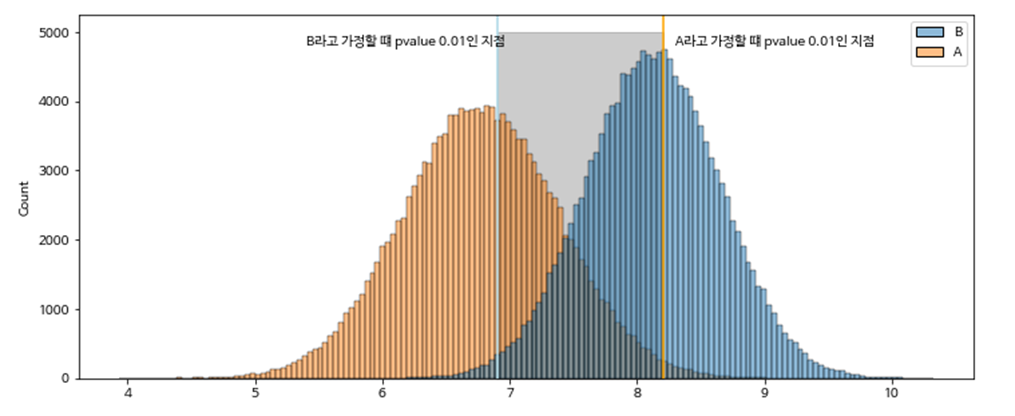

In [57]:
# 참고용 코드입니다.

from sklearn.mixture import GaussianMixture
from scipy.stats import norm

# Gaussian Mixture 모델로 target을 가우시안 혼합 모델로 두 개의 군집으로 나눕니다.
gmm = GaussianMixture(n_components=2, random_state=123)
gmm.fit(df_train[['target']])
gmm.means_, gmm.covariances_

mu_ = np.squeeze(gmm.means_)
mu_A = mu_[np.argmin(mu_)]
mu_B = mu_[np.argmax(mu_)]

var_ = np.squeeze(gmm.covariances_)
std_A = var_[np.argmin(mu_)] ** 0.5
std_B = var_[np.argmax(mu_)] ** 0.5

mu_A, std_A, mu_B, std_B

(6.770724541567276, 0.6170677431106549, 8.12395937973029, 0.5269927854538631)

## 단계 3-1

A 범주의 평균은 6.769 표준편차는 0.616이고 범주 B일 때 평균은 8.123 표준편차는 0.527이다. 

측정한 값을 범주A, B의 모집단의 target의 평균과 표준편차라고 가정한다. 

두 개의 정규 분포를 이용하여, 귀무가설이 ‘target은 A 범주에 해당한다’일 때 p-value를 구하여 파생변수(prob_A)를 만들다. 

반대로, 귀무가설이 ‘target은 B 범주에 해당한다’일 때 p-value를 구하여 파생변수(prob_B)를 만든다.

basetable에 두 개의 파생 변수 prob_A, prob_B를 추가하여 prob3 데이터프레임을 만든다.

---
**함수가이드**

scipy.stats 제공 기능 활용

문제 지시사항 외 Default 값 사용

---

In [38]:
from scipy.stats import norm
mu_A, std_A = 6.769, 0.616
mu_B, std_B = 8.123, 0.527
# 귀무가설이 target은 A범주에 해당한다는 target을 기준으로 N(mu_A, std_A^2)의 우측 꼬리의 영역이 pvalue이고
# 귀무가설이 target은 B범주에 해당한다는 target을 기준으로 N(mu_B, std_B^2)의 좌측 꼬리의 영역이 pvalue입니다.
# norm의 loc은 평균, scale은 표준편차를 의미합니다.
# 만일 문제에서 표준편차가 아니라 분산을 제시한다면 scale에는 scale=var_A ** 0.5 or scale=np.sqrt(var_A) 로
# 전달해야겠지만, 표준편차이므로 그대로 scale=std_A 전달하면 됩니다.
df_prob3 = df_basetable.assign(
    prob_A = lambda x: 1 - norm.cdf(x['target'],  loc=mu_A, scale=std_A),
    prob_B = lambda x: norm.cdf(x['target'], loc=mu_B, scale=std_B)
)
df_prob3.head()

cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...    cont8  \
id                                                        ...            
267387    A    B    B    C    B    B    A    E    G    G  ...  0.47134   
410037    A    A    A    A    B    B    A    E    C    F  ...  0.40193   
139373    A    A    B    A    B    B    A    E    C    J  ...  0.40112   
113765    A    A    A    C    B    B    A    E    C    G  ...  0.46425   
179915    A    B    A    C    B    B    A    E    E    L  ...  0.75578   

          cont9   cont10   cont11   cont12   cont13   target  targetA  \
id                                                                      
267387  0.53290  0.97139  0.59414  0.36856  0.42951  8.13741    False   
410037  0.49181  0.56479  0.39386  0.36247  0.71541  7.40427     True   
139373  0.53052  0.35635  0.33341  0.33354  0.82542  7.98022    False   
113765  0.38302  0.38054  0.68827  0.34895  0.73375  7.26085     True   
179915  0.55676  0.31308  0.43157  0.32302  0.18028  7.26448     True   

          prob_A    prob_B  
id                          
267387  0.013160  0.510907  
410037  0.151204  0.086313  
139373  0.024634  0.393223  
113765  0.212302  0.050924  
179915  0.210597  0.051649  

[5 rows x 28 columns]

## 단계 3-2

prob3 중에서 target이 A 또는 B라고 신뢰할 수 있는 행들만을 골라내고자 한다.

prob_B가 0.01 미만이거나, prob_A가 0.01 미만인 것만 남긴다. (즉, 위 그림에서 회색 영역에 해당하는 부분은 제외)

Hint] 행의 개수는 124,600가 된다.

In [39]:
df_prob3 = df_prob3.query('prob_A < 0.01 or prob_B < 0.01').copy()
len(df_prob3)

124600

In [40]:
# 다른 방법입니다.
# cdf의 역함수인 ppf를 이용하여 각각의 임계점을 산출하여 해당 행들만을 뽑아낼 수 있습니다.
df_prob3.loc[
    (df_prob3['target'] > norm.ppf(0.99, loc=mu_A, scale=std_A)) |
    (df_prob3['target'] < norm.ppf(0.01, loc=mu_B, scale=std_B))
]

cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...    cont8  \
id                                                        ...            
29503     A    B    A    C    B    B    A    E    E    F  ...  0.30163   
113326    A    B    A    A    B    D    A    E    C    H  ...  0.65004   
199507    A    B    B    A    B    B    A    E    A    L  ...  0.22571   
346281    A    A    A    D    B    D    A    E    C    F  ...  0.45999   
137333    A    A    A    C    B    D    A    D    C    K  ...  0.49416   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...      ...   
76711     A    B    A    C    B    D    A    D    E    F  ...  0.85100   
215151    A    B    B    C    B    B    A    E    E    F  ...  0.31602   
244056    A    B    A    C    B    B    A    E    E    F  ...  0.33881   
324013    A    B    B    C    B    D    A    E    G    F  ...  0.45223   
463191    A    A    A    C    B    D    A    E    E    F  ...  0.06595   

          cont9   cont10   cont11   cont12   cont13   target  targetA  \
id                                                                      
29503   0.32551  0.26982  0.19329  0.39034  0.30002  6.66255     True   
113326  0.63958  0.60535  0.70951  0.71664  0.78782  5.98141     True   
199507  0.48717  0.33999  0.51461  0.37367  0.69462  6.60870     True   
346281  0.79100  0.62269  0.83624  0.78785  0.30893  5.42339     True   
137333  0.89742  0.59422  0.72298  0.72535  0.82115  8.34177    False   
...         ...      ...      ...      ...      ...      ...      ...   
76711   0.26369  0.24340  0.22768  0.83386  0.49068  8.42823    False   
215151  0.55754  0.76485  0.80875  0.28582  0.74923  8.78659    False   
244056  0.40674  0.24883  0.20810  0.55646  0.29033  8.54518    False   
324013  0.83345  0.18835  0.63630  0.71323  0.39620  8.27334    False   
463191  0.61991  0.62167  0.25545  0.33329  0.28366  6.64854     True   

          prob_A        prob_B  
id                              
29503   0.568599  2.792056e-03  
113326  0.899473  2.414650e-05  
199507  0.602656  2.030176e-03  
346281  0.985535  1.506759e-07  
137333  0.005337  6.609742e-01  
...          ...           ...  
76711   0.003535  7.187675e-01  
215151  0.000528  8.960181e-01  
244056  0.001967  7.884633e-01  
324013  0.007301  6.122833e-01  
463191  0.577520  2.572305e-03  

[124600 rows x 28 columns]

## 단계 3-3

prob3에 cat0 ~ 9를 제외하는 범주 없이 원핫 인코딩(One-Hot Encoding) 한다. 


In [42]:
df_prob3 = pd.get_dummies(df_prob3, columns=['cat{}'.format(i) for i in range(10)])
df_prob3.shape

(124600, 57)

## 단계 3-4

prob3를 학습용 80%, 그 외 20%는 테스트용으로 나누어 prob3_train, prob3_test로 한다.


---
**함수가이드**

sklearn.model_selection.train_test_split, random_state=123

문제 지시사항 외 Default 값 사용

---

In [43]:
from sklearn.model_selection import train_test_split
df_prob3_train, df_prob3_test = train_test_split(df_prob3, train_size=0.8, random_state=123)
df_prob3_train, df_prob3_test = df_prob3_train.copy(), df_prob3_test.copy()

## 단계 3-5

prob3_train으로 target_A를 예측하는 xgboost 분류 모델을 다음과 같은 설정으로 prob3_train를 사용하여 학습한다. 

prob3_test으로 다음 성능지표로 평가한 값을 C 라고 한다.

입력변수: cont0 ~ 13, cat0 ~ 9까지 원핫-인코딩 파생 변수 (변수명, 범주순으로 알파벳 순서)

대상변수: targetA

성능지표: $Accuracy(Y, \hat{Y})=\frac{TP+TN}{TP+FP+TN+FN}$

하이퍼 파라미터(Hyper-Parameter, 초매개변수) 설정: 

|항목|값|
|----|--|
|트리의 최대 깊이|2|
|L1 규제|0.1|
|L2 규제|0.1|
|트리 당 컬럼 샘플링 비율|0.25|
|트리의 수|500|
|random_state|123|

---
**함수가이드**

xgboost 제공 기능 활용

문제 지시사항 외 Default 값 사용

----


In [54]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
clf_xgb = xgb.XGBClassifier(
    max_depth=2, # 트리의 최대 깊이: 2
    reg_alpha=0.1, # L1 규제: 0.1
    reg_lambda=0.1, # L2 규제: 0.1
    colsample_bytree=0.25, # 트리 당 컬럼 샘플링 비율: 0.25
    n_estimators=500, # 트리의 수: 500
    random_state=123
)
X_xgb = ['cont{}'.format(i) for i in range(14)] + [i for i in df_prob3_train.columns if i.startswith('cat')]
clf_xgb.fit(df_prob3_train[X_xgb], df_prob3_train['targetA'])
accuracy_score(df_prob3_train['targetA'], clf_xgb.predict(df_prob3_train[X_xgb]))

0.6661918138041734

In [55]:
C = accuracy_score(df_prob3_test['targetA'], clf_xgb.predict(df_prob3_test[X_xgb]))
C

0.6547351524879614

C 를 소수점 넷째 자리에서 반올림하여 셋째 자리까지 출력하라.

**0.655**

# 문제 4
 
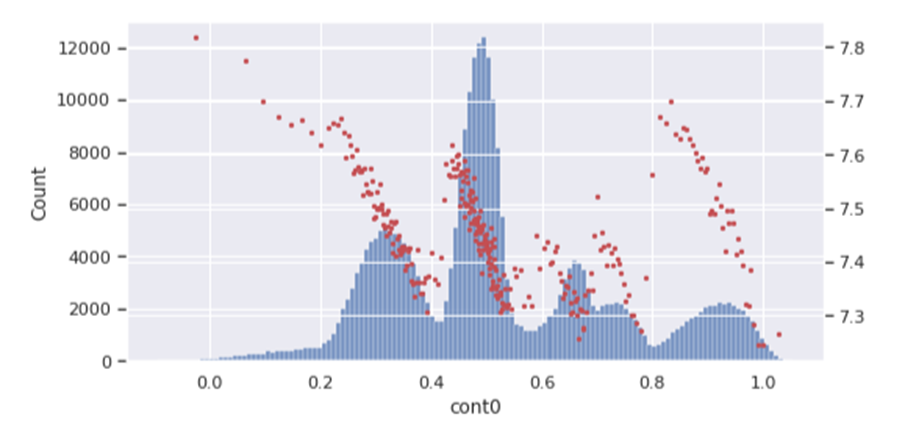

위 차트는 cont0 의 히스토그램과 cont0를 300개의 분위 구간으로 나누어 x값은 분위 구간의 중간값, 

y값은 분위 구간에서 target의 평균을 산포도 그래프로 동시에 출력했다. 

좌측 y축은 히스토그램의 빈도수이고, 우측 y축은 target의 평균이다. 

히스토그램에서 동일한 봉우리 구간 내에서 cont0와 target간에 선형적 관계가 있음이 확인되었다. 

이 점을 이용하여 파생 변수를 만들어서 회귀모델을 만들어 간다.

## 단계 4-1

basetable에서 cat0 ~ 9을 첫 번째 범주(알파벳 순)는 제외하고 원핫 인코딩(One-Hot Encoding)하여 prob4데이터셋을 만든다.

In [61]:
df_prob4 = pd.get_dummies(df_basetable, columns=['cat{}'.format(i) for i in range(10)], drop_first=True)
df_prob4.head()

cont0    cont1    cont2    cont3    cont4    cont5    cont6  \
id                                                                      
267387  0.65226  0.55771  0.25398  0.28196  0.82400  0.22443  0.69220   
410037  0.36970  0.68159  0.30038  0.20156  0.46113  0.43278  0.97199   
139373  0.47881  0.63976  0.40024  0.24153  0.27128  0.36238  0.41310   
113765  0.43438  0.77575  0.54887  0.21935  0.27944  0.32670  0.42301   
179915  0.47866  0.64326  0.37255  0.21004  0.41188  0.20121  0.37466   

          cont7    cont8    cont9  ...  cat9_F  cat9_G  cat9_H  cat9_I  \
id                                 ...                                   
267387  0.30912  0.47134  0.53290  ...       0       1       0       0   
410037  0.62596  0.40193  0.49181  ...       1       0       0       0   
139373  0.27010  0.40112  0.53052  ...       0       0       0       0   
113765  0.28331  0.46425  0.38302  ...       0       1       0       0   
179915  0.46316  0.75578  0.55676  ...       0       0       0       0   

        cat9_J  cat9_K  cat9_L  cat9_M  cat9_N  cat9_O  
id                                                      
267387       0       0       0       0       0       0  
410037       0       0       0       0       0       0  
139373       1       0       0       0       0       0  
113765       0       0       0       0       0       0  
179915       0       0       1       0       0       0  

[5 rows x 45 columns]

## 단계 4-2

prob4의 80%를 prob4_train으로 20% prob4_test로 나눈다.

---
**함수가이드**

sklearn.model_selection.train_test_split, random_state=123

---

In [62]:
from sklearn.model_selection import train_test_split
df_prob4_train, df_prob4_test = train_test_split(df_prob4, train_size=0.8, random_state=123)
df_prob4_train, df_prob4_test = df_prob4_train.copy(), df_prob4_test.copy()

## 단계 4-3

prob4_train에서 cont0를 100개의 우측이 닫힌 (ex. i번째 분위수 < cont0 ≤ i+1 번째 분위수) 분위 구간으로 나누고 

각각의 분위 구간에서 target의 평균을 구해 파생 변수 cont0_q를 만든다. 

prob4_test에는 prob4_train을 나누었던 구간과 평균으로 cont0_q를 만든다. 

이 때, prob4_test의 cont0값이 train의 첫 번째 구간보다 작다면, 첫 번째 구간으로 간주하고, 

마지막 구간보가 크다면, 마지막 구간으로 간주한다.

---
**함수가이드**

Hint 1] pandas.Series.quantile, pandas.cut 활용을 권장한다.

Hint 2] 두 번째 분위 구간은 0.111 < cont0 <= 0.176이고 target의 평균은 7.672 (셋째 자리까지 반올림)

Hint 3] cont0_q의 평균은 7.46, 표준 편차는 0.10 (소수점 둘째 자리까지 반올림)

---

In [87]:
# 100개의 분위 구간을 만들기 위해 최소점과 최대점을 포함하는 101개의 0~1사이 수열을 만듭니다.
q = [i * 0.01 for i in range(101)]
# train에서 101개의 분위수를 구합니다.
q_val = df_prob4_train['cont0'].quantile(q)
# train에 있던 수보다 작은 수는 첫번째 구간에 포함되게하기 위해 -np.inf를 첫번째 분위수에 넣고,
# train에 있던 수보다 큰  수는 마지막 구간에 포함되게하기 위해 np.inf를 마지막 분위수에 넣어줍니다.
q_val.iloc[[0, -1]] = [-np.inf, np.inf]
# 도출한 분위수로 구간화합니다.
q_cat = pd.cut(df_prob4_train['cont0'], bins=q_val, right=True)
# 분위구간의 평균을 구합니다.
q_mean = df_prob4_train.groupby(q_cat)['target'].mean()
# 분위구간 마다 평균으로 맵핑합니다.
df_prob4_train['cont0_q'] = q_cat.map(q_mean).astype('float')
# train의 설정으로 test의 분위 구간을 만들어 train에 구한 평균 정보로 맵핑합니다.
df_prob4_test['cont0_q'] = \
                pd.cut(df_prob4_test['cont0'], bins=q_val, right=True).map(q_mean).astype('float')

## 단계 4-4

나머지 변수 cont1~13에 대해서도 해당 작업을 진행한다. 

생성한 파생 변수명은 원래의 변수명에 _q를 결합한다. (ex. cont1 -> cont1_q)

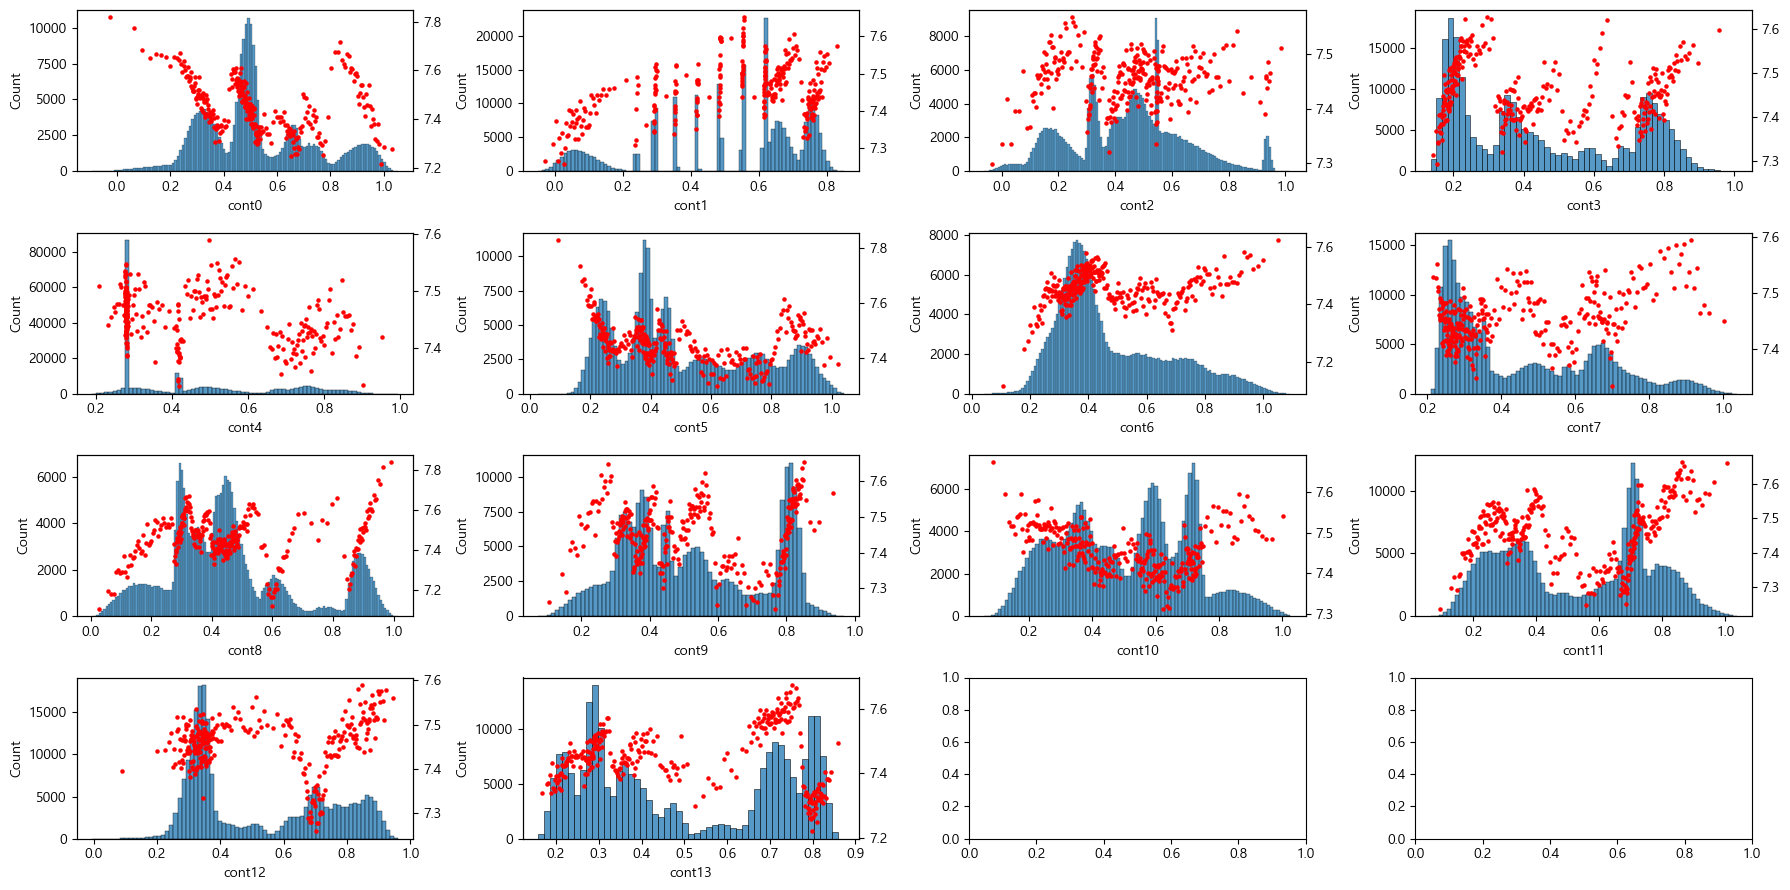

In [88]:
# 다른 변수에 대해서도 그래프를 출력해 봅니다.

fig, axes = plt.subplots(4, 4, figsize=(18, 9))
for i, ax in enumerate(axes.ravel()[:14]):
    col = 'cont{}'.format(i)
    sns.histplot(data=df_train, x=col, ax=ax)
    tmp = df_train.groupby(pd.qcut(df_train[col], q=300))[['target']].mean()
    ax.twinx().scatter((tmp.index.categories.left + tmp.index.categories.right) / 2, 
                       tmp['target'], c='r', s=5)
plt.tight_layout()
plt.show()

In [90]:
q = [i * 0.01 for i in range(101)]
for i in range(1, 14):
    col = 'cont{}'.format(i)
    col_q = col + '_q' 
    q_val = df_prob4_train[col].quantile(q)
    q_val.iloc[[0, -1]] = [-np.inf, np.inf]
    q_cat = pd.cut(df_prob4_train[col], bins=q_val, right=True)
    q_mean = df_prob4_train.groupby(q_cat)['target'].mean()
    df_prob4_train[col_q] = q_cat.map(q_mean).astype('float')
    df_prob4_test[col_q] = \
                    pd.cut(df_prob4_test[col], bins=q_val, right=True).map(q_mean).astype('float')
df_prob4_train.head()

cont0    cont1    cont2    cont3    cont4    cont5    cont6  \
id                                                                      
487693  0.49355  0.69104  0.66940  0.46424  0.78825  0.34951  0.30596   
307175  0.66260  0.55180  0.31117  0.83165  0.22354  0.34808  0.65781   
493409  0.87161  0.69037  0.33452  0.69755  0.28069  0.93415  0.63591   
414858  0.51951  0.03523  0.32366  0.38940  0.41430  0.73061  0.37822   
408161  0.86293  0.61935  0.70905  0.82617  0.41898  0.43902  0.31892   

          cont7    cont8    cont9  ...   cont4_q   cont5_q   cont6_q  \
id                                 ...                                 
487693  0.69445  0.19411  0.35497  ...  7.444439  7.507718  7.418108   
307175  0.30914  0.48613  0.59179  ...  7.464061  7.507718  7.447277   
493409  0.87033  0.93617  0.79620  ...  7.462176  7.471819  7.454580   
414858  0.62359  0.34185  0.38249  ...  7.371190  7.354649  7.498205   
408161  0.58007  0.37662  0.37795  ...  7.406167  7.465528  7.446922   

         cont7_q   cont8_q   cont9_q  cont10_q  cont11_q  cont12_q  cont13_q  
id                                                                            
487693  7.424195  7.466343  7.391288  7.494510  7.489119  7.450950  7.357680  
307175  7.431217  7.424309  7.305747  7.434794  7.436207  7.481821  7.426932  
493409  7.537384  7.684391  7.384950  7.377006  7.615075  7.558415  7.483465  
414858  7.464006  7.428804  7.437616  7.456432  7.375974  7.447048  7.438021  
408161  7.391109  7.546018  7.418989  7.426295  7.338579  7.514672  7.337787  

[5 rows x 59 columns]

## 단계 4-5

prob4_train에서 target을 대상으로 선형회귀모델을 학습하고, 

prob4_test를 다음 지표로 성능 평가한 값을 D라고 한다. 

선형회귀 모델은 아래와 같은 손실함수로 학습을 한다.

$||Xw - y||^2_2 + \alpha||w||^2_2, \alpha = 0.1$

Hint] sklearn.linear_model.Ridge 또는 Lasso 중 요건에 맞는 것을 사용한다. 

입력 변수: cont0_q ~ cont13_q, cat0 ~ 9까지 원핫-인코딩 후 나온 파생 변수 (변수명 다음 범주명으로 알파벳 순서이다)

대상 변수: target

성능 지표: $MSE(Y, \hat{Y}) = \frac{1}{n}\sum^{n}_{i=1}(y_i-\hat{y_i})^2\$


In [94]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
clf_rd = Ridge(0.1)
X_rd = ['cont{}_q'.format(i) for i in range(14)] + [i for i in df_prob4_train.columns if i.startswith('cat')]
clf_rd.fit(df_prob4_train[X_rd], df_prob4_train['target'])
mean_squared_error(df_prob4_train['target'], clf_rd.predict(df_prob4_train[X_rd]))

0.7133970716556598

In [95]:
D = mean_squared_error(df_prob4_test['target'], clf_rd.predict(df_prob4_test[X_rd]))
D

0.7211650695566526

sklearn에서 제공하지 않은 지표는 직접 구현해봅니다

성능지표가 만일 MAPE로 주워 졌을 경우를 봅니다.

$MAPE(Y, \hat{Y}) = \frac{1}{n}\sum^{n}_{i=1}\frac{|y_i-\hat{y_i}|}{max(\epsilon, |y_i|)}\$

$\epsilon=1e-7$로 설정합니다.

In [111]:
# 참고용 코드입니다.

def mape(y, y_hat, eps=1e-7):
    """
    np를 이용한 함수로도 만들어 봅니다.
    """
    return np.mean(np.abs(y - y_hat) / np.abs(np.where(eps > y, eps, y)))

y = df_prob4_test['target']
y_hat = clf_rd.predict(df_prob4_test[X_rd])
mape_tmp = (y - y_hat).abs() / (y.abs().apply(lambda x: max(x, eps)))
mape_tmp.mean(), mape(df_prob4_test['target'], y_hat)

(0.09840996057388596, 0.09840996057388596)

D를 소수점 셋째 자리에서 반올림하여 둘째 자리까지 출력하라.

**0.72**

# 문제 5


XGBoost 분류 모델의 최적의 하이퍼 파라미터(Hyper-Parameter, 초매개변수)를 탐색한다.

## 단계 5-1

basetable에 cat0 ~ 9 제외하는 범주 없이 원핫 인코딩(One-Hot Encoding) 하여 prob5를 만든다.


In [113]:
df_prob5 = pd.get_dummies(df_basetable, columns=['cat{}'.format(i) for i in range(10)])
df_prob5.head()

cont0    cont1    cont2    cont3    cont4    cont5    cont6  \
id                                                                      
267387  0.65226  0.55771  0.25398  0.28196  0.82400  0.22443  0.69220   
410037  0.36970  0.68159  0.30038  0.20156  0.46113  0.43278  0.97199   
139373  0.47881  0.63976  0.40024  0.24153  0.27128  0.36238  0.41310   
113765  0.43438  0.77575  0.54887  0.21935  0.27944  0.32670  0.42301   
179915  0.47866  0.64326  0.37255  0.21004  0.41188  0.20121  0.37466   

          cont7    cont8    cont9  ...  cat9_F  cat9_G  cat9_H  cat9_I  \
id                                 ...                                   
267387  0.30912  0.47134  0.53290  ...       0       1       0       0   
410037  0.62596  0.40193  0.49181  ...       1       0       0       0   
139373  0.27010  0.40112  0.53052  ...       0       0       0       0   
113765  0.28331  0.46425  0.38302  ...       0       1       0       0   
179915  0.46316  0.75578  0.55676  ...       0       0       0       0   

        cat9_J  cat9_K  cat9_L  cat9_M  cat9_N  cat9_O  
id                                                      
267387       0       0       0       0       0       0  
410037       0       0       0       0       0       0  
139373       1       0       0       0       0       0  
113765       0       0       0       0       0       0  
179915       0       0       1       0       0       0  

[5 rows x 55 columns]

## 단계 5-2

prob5를 80%는 학습용 prob5_train으로, 20%는 테스트용 prob5_test로 나눈다.

---
**함수가이드**

sklearn.model_selection.train_test_split, random_state=123

문제 지시사항 외 Default 값 사용

---

In [114]:
from sklearn.model_selection import train_test_split
df_prob5_train, df_prob5_test = train_test_split(df_prob5, train_size=0.8, random_state=123)
df_prob5_train, df_prob5_test = df_prob5_train.copy(), df_prob5_test.copy()

## 단계 5-3

다음 회귀 분석 모델을 아래 3개의 하이퍼 파라미터(Hyper-Parameter, 초매개변수)를 사용하여 

prob5_train으로 target를 학습시킨다.

prob5_test으로 테스트했을 때 , 최적의 성능을 낸 하이퍼 파라미터 셋의 번호를 A, 성능지표를 B라고 한다.

입력 변수] cont0~13, cat0 ~ 9을 원핫 인코딩하여 나온 파생 변수(변수명, 범주명 알파벳순)


대상 변수] target


성능 지표] $MSE(Y, \hat{Y}) = \frac{1}{n}\sum^{n}_{i=1}(y_i-\hat{y_i})^2\$
 
|No|하이퍼 파라미터(Hyper-parameter, 초매개변수)|
|--|--------------------------------------------|
|1|colsample_bytree=0.25, n_estimators=300|
|2|colsample_bytree=0.5, n_estimators=300|
|3|colsample_bytree=0.25, n_estimators=500|

공통적으로 트리의 최대 깊이는 2, 랜덤 시드는 123 이다.

---
**함수가이드**

xgboost 제공 기능 활용

문제 지시사항 외 Default 값 사용

---

In [118]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
X_xgb = ['cont{}'.format(i) for i in range(14)] + [i for i in df_prob5_train.columns if i.startswith('cat')]
param_list = [
    {'colsample_bytree': 0.25, 'n_estimators': 300},
    {'colsample_bytree': 0.5, 'n_estimators': 300},
    {'colsample_bytree': 0.25, 'n_estimators': 500}
]
best_param, best_score = None, np.inf
for param in param_list:
    reg_xgb = xgb.XGBRegressor(max_depth=2, random_state=123, **param)
    reg_xgb.fit(df_prob5_train[X_xgb], df_prob5_train['target'])
    score = mean_squared_error(df_prob5_test['target'], reg_xgb.predict(df_prob5_test[X_xgb]))
    if best_score > score:
        best_score = score
        best_param = param
    print(param, score, best_param, best_score)
best_param, best_score

{'colsample_bytree': 0.25, 'n_estimators': 300} 0.7215793793731834 {'colsample_bytree': 0.25, 'n_estimators': 300} 0.7215793793731834
{'colsample_bytree': 0.5, 'n_estimators': 300} 0.721219679405562 {'colsample_bytree': 0.5, 'n_estimators': 300} 0.721219679405562
{'colsample_bytree': 0.25, 'n_estimators': 500} 0.7164353991627278 {'colsample_bytree': 0.25, 'n_estimators': 500} 0.7164353991627278


({'colsample_bytree': 0.25, 'n_estimators': 500}, 0.7164353991627278)

In [119]:
A, B = 3, best_score
A, B, A + B

(3, 0.7164353991627278, 3.716435399162728)

A + B 를 소수점 셋째 자리에서 반올림하여 둘째 자리까지 구하라.

**3.72**

# 쉬는 시간: ~16:22